In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from math import sqrt
from scipy.stats import norm
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix


In [3]:
df_orig = pd.read_csv('/content/drive/MyDrive/CERC/Stat test Safecity/sample_200_train_prompts.csv')
df_manual = pd.read_excel('/content/drive/MyDrive/CERC/Stat test Safecity/Manually_labeled_200_train_prompts.xlsx')

In [4]:
df_orig.head()

,Statement,label
0,The so called 'new age' chhokras of the city h...,"[1,1,0]"
1,An old man was trying touching my friend again...,"[0,0,1]"
2,Chatting and befriending different people on f...,"[0,0,0]"
3,i was with my friends wet in the rain and some...,"[1,1,0]"
4,She was touched at private parts by her dance ...,"[0,0,1]"


In [5]:
df_manual.head()

,Statement,label
0,The so called 'new age' chhokras of the city h...,"[0,0,0]"
1,An old man was trying touching my friend again...,"[0,0,1]"
2,Chatting and befriending different people on f...,"[1,0,0]"
3,i was with my friends wet in the rain and some...,"[1,0,0]"
4,She was touched at private parts by her dance ...,"[0,0,1]"


In [6]:
df_merged = pd.merge(df_orig, df_manual, on='Statement', suffixes=('_true', '_manual'))

In [7]:
df_final = df_merged[['Statement', 'label_true', 'label_manual']]

In [8]:
# Converting both label columns to actual lists
df_final['label_true'] = df_final['label_true'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final['label_manual'] = df_final['label_manual'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print(type(df_final['label_true'][0]), df_final['label_true'][0])
print(type(df_final['label_manual'][0]), df_final['label_manual'][0])

<class 'list'> [1, 1, 0]
<class 'list'> [0, 0, 0]


In [9]:
## Splitting the lists into separate columns
df_split_true = df_final['label_true'].apply(pd.Series)
df_split_true.columns = ['commenting_true', 'ogling_true', 'groping_true']

df_split_manual = df_final['label_manual'].apply(pd.Series)
df_split_manual.columns = ['commenting_manual', 'ogling_manual', 'groping_manual']

df_full = pd.concat([df_final[['Statement']], df_split_true, df_split_manual], axis=1)


print(df_full.head())

                                           Statement  commenting_true  \
0  The so called 'new age' chhokras of the city h...                1   
1  An old man was trying touching my friend again...                0   
2  Chatting and befriending different people on f...                0   
3  i was with my friends wet in the rain and some...                1   
4  She was touched at private parts by her dance ...                0   

   ogling_true  groping_true  commenting_manual  ogling_manual  groping_manual  
0            1             0                  0              0               0  
1            0             1                  0              0               1  
2            0             0                  1              0               0  
3            1             0                  1              0               0  
4            0             1                  0              0               1  


In [10]:
df_full['commenting_mismatch'] = df_full['commenting_true'] != df_full['commenting_manual']
df_full['ogling_mismatch'] = df_full['ogling_true'] != df_full['ogling_manual']
df_full['groping_mismatch'] = df_full['groping_true'] != df_full['groping_manual']

# Counting the mismatches
commenting_mismatches = df_full['commenting_mismatch'].sum()
ogling_mismatches = df_full['ogling_mismatch'].sum()
groping_mismatches = df_full['groping_mismatch'].sum()


In [11]:
print(f"Commenting Mismatches: {commenting_mismatches}")
print(f"Ogling Mismatches: {ogling_mismatches}")
print(f"Groping Mismatches: {groping_mismatches}")

Commenting Mismatches: 44
Ogling Mismatches: 43
Groping Mismatches: 28


## Z- Test

In [12]:

n = 200
def one_proportion_z_test(x, n, p0=0.1, label="Label"):
    p_hat = x / n
    se = sqrt(p0 * (1 - p0) / n)
    z = (p_hat - p0) / se
    p_value = 1 - norm.cdf(z)  # one-sided test

    print(f"{label}")
    print(f"Mismatches: {x}/{n} ({p_hat:.2%})")
    print(f"Z = {z:.3f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Reject H0: Mismatch rate is significantly greater than 5%.\n")
    else:
        print("Fail to reject H0: No significant evidence of poor labeling.\n")


one_proportion_z_test(commenting_mismatches, n, label="Commenting")
one_proportion_z_test(ogling_mismatches, n, label="Ogling")
one_proportion_z_test(groping_mismatches, n, label="Groping")

Commenting
Mismatches: 44/200 (22.00%)
Z = 5.657, p-value = 0.0000
Reject H0: Mismatch rate is significantly greater than 5%.

Ogling
Mismatches: 43/200 (21.50%)
Z = 5.421, p-value = 0.0000
Reject H0: Mismatch rate is significantly greater than 5%.

Groping
Mismatches: 28/200 (14.00%)
Z = 1.886, p-value = 0.0297
Reject H0: Mismatch rate is significantly greater than 5%.



### Z test with multiple proportion thresholds

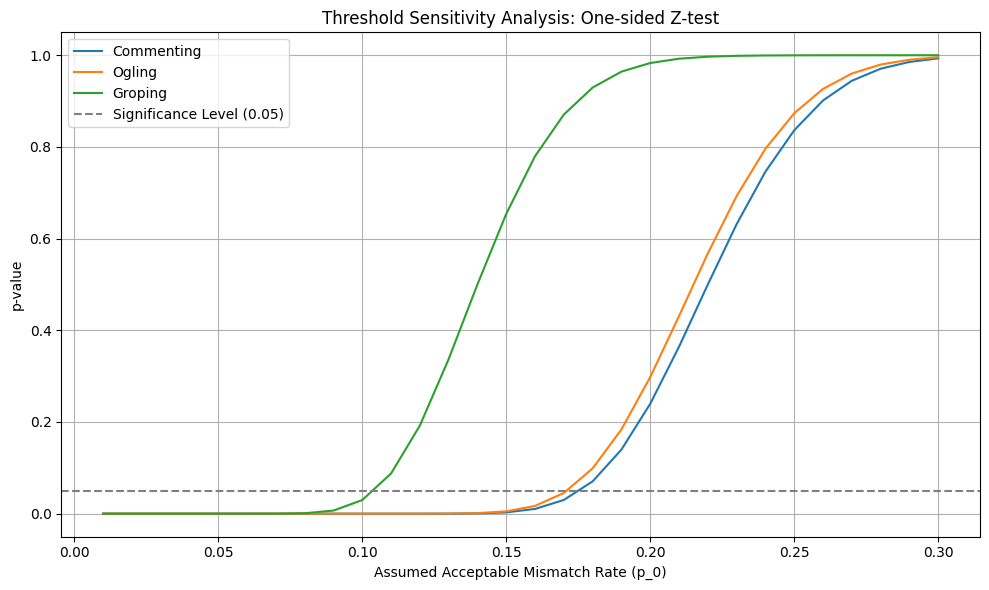

In [13]:
# Sample size
n = 200

# mismatches
mismatches = {
    "Commenting": 44,
    "Ogling": 43,
    "Groping": 28
}

### Testing the hypothesis with multiple threshold values ( 1% to 30% at 1% intervals)
p0_values = np.arange(0.01, 0.31, 0.01)  # From 0.01 to 0.30 at 0.01 (1%) intervals

threshold_results = {}

for label, x in mismatches.items():
    p_hat = x / n
    z_scores = []
    p_values = []

    for p0 in p0_values:
        # Standard error
        se = np.sqrt(p0 * (1 - p0) / n)
        # Z-score
        z = (p_hat - p0) / se
        # One-sided p-value
        p_val = 1 - norm.cdf(z)
        z_scores.append(z)
        p_values.append(p_val)

    threshold_results[label] = {
        "z_scores": z_scores,
        "p_values": p_values
    }

# Plotting p-values vs threshold
plt.figure(figsize=(10, 6))
for label in mismatches.keys():
    plt.plot(p0_values, threshold_results[label]["p_values"], label=label)

plt.axhline(0.05, color='gray', linestyle='--', label="Significance Level (0.05)")
plt.xlabel("Assumed Acceptable Mismatch Rate (p_0)")
plt.ylabel("p-value")
plt.title("Threshold Sensitivity Analysis: One-sided Z-test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [14]:
### Finding the thershold from where we fail to reject the Null Hypothesis

for label in mismatches.keys():
    p_vals = np.array(threshold_results[label]["p_values"])
    index = np.argmax(p_vals >= 0.05)
    critical_p0 = p0_values[index] if p_vals[index] >= 0.05 else None
    print(f"{label}: We fail to reject null hypothesis starting at p_0 ≈ {critical_p0:.3f}")

Commenting: We fail to reject null hypothesis starting at p_0 ≈ 0.180
Ogling: We fail to reject null hypothesis starting at p_0 ≈ 0.180
Groping: We fail to reject null hypothesis starting at p_0 ≈ 0.110


## McNemars Test

In [15]:
def run_mcnemar_test(col_true, col_manual, label_name):
    # Create a 2x2 contingency table
    b = ((col_true == 0) & (col_manual == 1)).sum()  # Original said 0, manual said 1
    c = ((col_true == 1) & (col_manual == 0)).sum()  # Original said 1, manual said 0

    table = [[0, b],
             [c, 0]]

    result = mcnemar(table, exact=True)  # Use exact test for small samples

    print(f"McNemar's Test for {label_name}")
    print(f"b (False Negatives): {b}, c (False Positives): {c}")
    print(f"Statistic: {result.statistic}, p-value: {result.pvalue}")
    if result.pvalue < 0.05:
        print("Reject the null hypothesis: There is significant disagreement.\n")
    else:
        print("Fail to reject the null hypothesis: No significant disagreement.\n")

# Apply test to each class
run_mcnemar_test(df_full['commenting_true'], df_full['commenting_manual'], "Commenting")
run_mcnemar_test(df_full['ogling_true'], df_full['ogling_manual'], "Ogling")
run_mcnemar_test(df_full['groping_true'], df_full['groping_manual'], "Groping")


McNemar's Test for Commenting
b (False Negatives): 20, c (False Positives): 24
Statistic: 20.0, p-value: 0.651587827208914
Fail to reject the null hypothesis: No significant disagreement.

McNemar's Test for Ogling
b (False Negatives): 24, c (False Positives): 19
Statistic: 19.0, p-value: 0.542384011856484
Fail to reject the null hypothesis: No significant disagreement.

McNemar's Test for Groping
b (False Negatives): 22, c (False Positives): 6
Statistic: 6.0, p-value: 0.0037191659212112427
Reject the null hypothesis: There is significant disagreement.

